In [1]:
from model import Simulation,run_sim
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
log = False
from joblib import Parallel, delayed

initing cache...


In [2]:
def draw(G):
    nx.draw(G, with_labels= True, node_color=list(nx.get_node_attributes(G, "opinion").values()))

In [3]:
simul = Simulation(N=600, avg_degree=10, p=0.6, phi=0, num_opinions=30)
G = simul.graph
if log:    
    print(simul.graph.edges)
    print(nx.get_node_attributes(G, "opinion"))
    draw(G)

{23: 12, 132: 11, 177: 14, 190: 15, 410: 22, 541: 3, 250: 3, 260: 3, 0: 10, 414: 28, 25: 25, 587: 9, 1: 15, 342: 22, 241: 24, 440: 15, 99: 17, 356: 9, 90: 13, 307: 15, 2: 11, 423: 24, 230: 6, 467: 7, 37: 10, 152: 16, 330: 11, 554: 1, 326: 26, 520: 3, 280: 4, 324: 11, 86: 13, 193: 28, 371: 6, 442: 24, 311: 23, 87: 13, 503: 24, 96: 30, 243: 15, 290: 10, 337: 14, 176: 8, 352: 16, 379: 16, 531: 8, 9: 11, 211: 23, 14: 13, 289: 13, 463: 15, 530: 14, 334: 7, 416: 15, 3: 17, 545: 28, 97: 8, 323: 14, 184: 6, 328: 27, 264: 25, 320: 2, 341: 24, 540: 21, 34: 29, 389: 10, 118: 5, 382: 17, 593: 26, 397: 20, 557: 15, 297: 17, 390: 25, 94: 24, 519: 3, 388: 20, 508: 6, 221: 1, 480: 1, 402: 19, 401: 10, 447: 29, 346: 22, 511: 4, 393: 3, 443: 4, 357: 9, 303: 22, 549: 7, 202: 27, 466: 7, 48: 6, 408: 6, 564: 9, 125: 23, 399: 24, 105: 25, 570: 6, 16: 25, 492: 2, 398: 12, 426: 16, 476: 7, 236: 19, 318: 29, 534: 11, 203: 12, 124: 5, 174: 17, 142: 21, 308: 13, 112: 29, 103: 3, 347: 24, 597: 1, 219: 30, 411: 2,

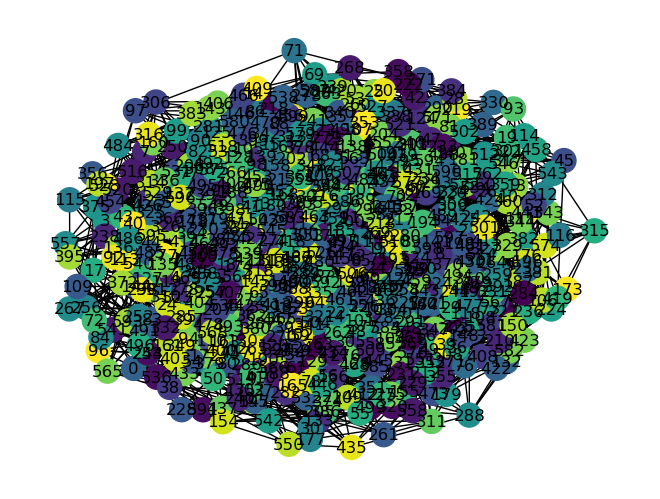

In [4]:
#for _ in range(5) :
#    simul.step()
log = True
if log:
    print(nx.get_node_attributes(G, "opinion"))
    draw(G)

In [ ]:
log = False
simul.run()
print(simul.status, simul.time, simul.stall)
print(simul.num_surviving_opinions)
print(simul.stall_bin)

In [ ]:
draw(G)

In [6]:
def mean(runs, func, *args):
    sum = 0
    count = 0
    for i in range(runs):
        res = func(*args) 
        if res >= 0:
            sum += res
            count += 1
    return sum/count if count > 0 else -1 

In [7]:
def contour_plot_number_of_surviving_opinions(N=100, runs=50, avg_degree=10, num_opinions=4, p_count=20, phi_count=20):
    def run_with_params(p, phi,run):
        simul = run_sim(N=N, avg_degree=avg_degree, p=p, phi=phi, num_opinions=num_opinions, run=run)
        simul.run_retry()
        return simul.num_surviving_opinions

    p_range = np.linspace(0, 1, p_count)
    phi_range = np.linspace(0, 1, phi_count)
    P, PHI = np.meshgrid(p_range, phi_range)
    params = np.dstack((P, PHI)).reshape(-1,2)

    results = Parallel(n_jobs=7)(delayed(mean)(runs, run_with_params, p, phi) for p,phi in params)
    surviving_opinions = np.array(results)
    Z = surviving_opinions.reshape(PHI.shape)
    contour = plt.contourf(P, PHI, Z, levels=list(np.arange(1, num_opinions + 0.1, 0.1)), cmap='jet')
    plt.colorbar(contour).ax.invert_yaxis()
    plt.ylabel('Φ')
    plt.xlabel('p')


In [ ]:
contour_plot_number_of_surviving_opinions(N=600, avg_degree=5, p_count=10, phi_count=10, num_opinions=25, runs=30)

In [ ]:
# o objetivo seria este. Mas não sei se vai ser possível
contour_plot_number_of_surviving_opinions(N=1000, p_count=100, phi_count=100, phi_init=0, num_opinions=50, runs=100)

In [ ]:
# mais rápido de obter se não conseguirmos correr o de cima
contour_plot_number_of_surviving_opinions(N=800, p_count=50, phi_count=40, phi_init=0.2, num_opinions=30, runs=50)

In [2]:
def get_rank_distribution(G, normalized=True):  
    rank_sequence = list(nx.get_node_attributes(G, 'opinion').values())  # rank sequence
    rankCount = Counter(rank_sequence).most_common()
    aux_y = [c for o,c in rankCount]
    aux_x = list(range(1, len(aux_y)+1))

    n_nodes = G.number_of_nodes()
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    return aux_x, aux_y
    
def plot_rank_distribution(ax, G, normalized=True, label=''):
    aux_x, aux_y= get_rank_distribution(G, normalized=True)
    return ax.plot(aux_x, aux_y, '-o', label=label, markersize=7)

calling original function
saved to cache
calling original function
saved to cache


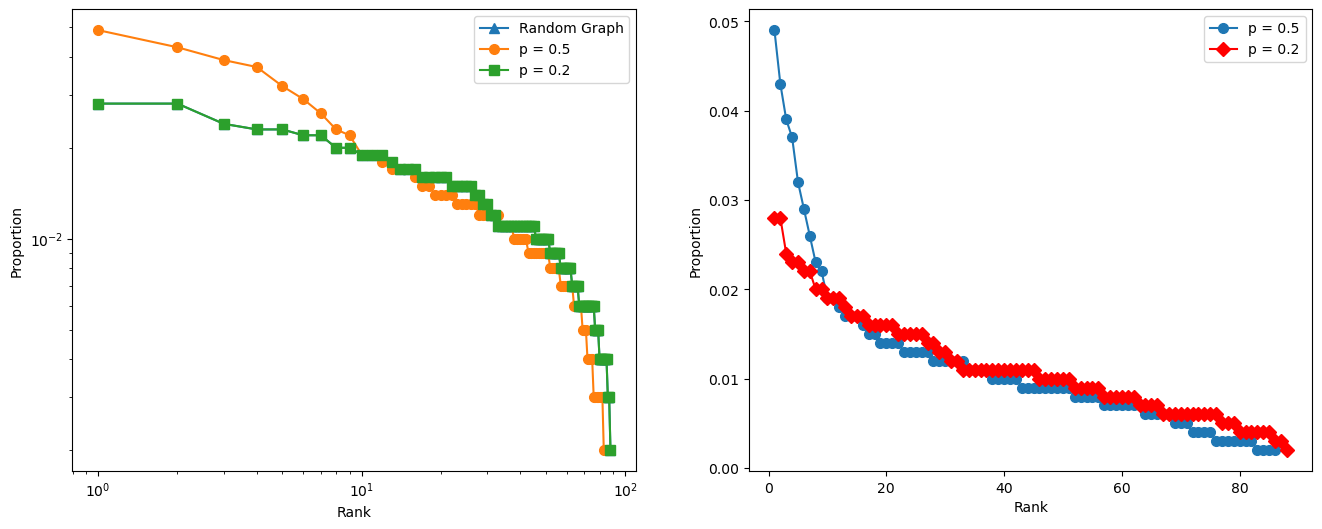

In [3]:
N = 1000
num_opinions = 100
simul = run_sim(N=N, avg_degree=10, num_opinions=num_opinions, phi=0.6, p=0.5)
simul2 = run_sim(N=N, avg_degree=10, num_opinions=num_opinions, phi=0.6, p=0.2)
initial_random_graph = simul2.graph.copy()
#simul3 = Simulation(N=N, avg_degree=10, num_opinions=num_opinions, phi=0.6, p=0.8) 
simul.run()
simul2.run_retry()
#simul3.run()
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(16,6))
ax.set_xlabel('Rank')
ax.set_ylabel('Proportion')
ax.set_xscale("log")
ax.set_yscale("log")
ax2.set_xlabel('Rank')
ax2.set_ylabel('Proportion')
plot1, = plot_rank_distribution(ax, initial_random_graph, normalized=True, label='Random Graph')
plot2, = plot_rank_distribution(ax, simul.graph, normalized=True, label='p = 0.5')
plot3, = plot_rank_distribution(ax, simul2.graph, normalized=True, label='p = 0.2')
plot4, = plot_rank_distribution(ax2, simul.graph, normalized=True, label='p = 0.5')
plot5, = plot_rank_distribution(ax2, simul2.graph, normalized=True, label='p = 0.2')
plot1.set_marker('^')
plot2.set_marker('o')
plot3.set_marker('s')
plot4.set_marker('o')
plot5.set_marker('D')
plot5.set_color('red')

ax.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')

In [12]:
def plot_phi_vs_final_number_of_opinions(N=100, p=0.2, phi_count=5, runs=10, avg_degree=10, num_opinions=10):
    def run_with_params(p, phi,run):
        simul = run_sim(N=N, avg_degree=avg_degree, p=p, phi=phi, num_opinions=num_opinions, run=run)
        simul.run_retry()
        return simul.num_surviving_opinions
    phi_range = np.linspace(0, 1, phi_count)
    results = Parallel(n_jobs=7)(delayed(mean)(runs, lambda p, phi, run: run_with_params(p, phi, run), phi,p) for phi in phi_range)
    surviving_opinions = np.array(results)
    plt.plot(phi_range, surviving_opinions, 'o')
    plt.xlabel('Φ')
    plt.ylabel('Number of opinions')
    plt.show()

In [ ]:
plot_phi_vs_final_number_of_opinions(N=1000, p=0.6, phi_count=20, runs=10, num_opinions=50)

In [ ]:
plot_phi_vs_final_number_of_opinions(N=600, p=0.6, phi_count=20, runs=200, num_opinions=30)

In [4]:
def plot_p_vs_consensus_time(N=100, phi=0.2, p_count=10, runs=10, avg_degree=10, num_opinions=10):
    def run_with_params(p, phi,run):
        simul = run_sim(N=1000, avg_degree=10, p=p, phi=phi, num_opinions=50, run=run)
        simul.run_retry()
        return simul.time
    p_range = np.linspace(0, 1, p_count)
    results = Parallel(n_jobs=7)(delayed(mean)(runs, run_with_params, p, phi) for p in p_range)
    consensus_time = np.array(results)
    return plt.plot(p_range, consensus_time, 'o', label=f'phi={phi}')

In [8]:
N = 1000
num_opinions = 50
phis =  [0.15, 0.3, 0.6]
markers = ['s', 'o', '^']
p_count = 5
runs = 100
for i in range(len(phis)):
    plot, = plot_p_vs_consensus_time(N=N, phi=phis[i], p_count=p_count, runs=runs, avg_degree=10, num_opinions=num_opinions)
    plot.set_marker(markers[i])
plt.xlabel('p')
plt.ylabel('Consensus time')
plt.legend(loc='upper right')

TypeError: run_with_params() missing 1 required positional argument: 'run'

In [ ]:
G = nx.Graph()
G.add_nodes_from(list(range(12)))
G.add_edges_from([(0,1), (1,5), (1,4), (2,1), (2,3), (2,5), (2,7), (2,11), (5,6), (6,7), (3,8), (3,10), (4,9)])
draw(G)

In [ ]:
from random import sample
def xulvi_brunet_sokolov(G, assort=True, turns=100, target=0.2):
    i=0
    sign = 1 if assort else -1
    curr_assortativity = nx.degree_assortativity_coefficient(G)
    while i < turns and sign * (curr_assortativity - target) < 0:
        switch_edges = sample(list(G.edges), 2)
        nodes = [n for e in switch_edges for n in e]
        if len(set(nodes)) != 4:
            continue
        nodes.sort(key=lambda n: G.degree[n])
        edge1 = (nodes[0], nodes[1])
        edge2 = (nodes[2], nodes[3])
        if not assort:
            edge1 = (nodes[0], nodes[3])
            edge2 = (nodes[1], nodes[2])
        if G.has_edge(*edge1) or G.has_edge(*edge2):
            continue
        G.remove_edges_from(switch_edges)
        G.add_edges_from([edge1, edge2])
        if(i%100):
            curr_assortativity = nx.degree_assortativity_coefficient(G)
        i+=1
    return nx.degree_assortativity_coefficient(G)

In [ ]:
import os
N = 1000
M = 5
turns = 3000
target = 0.35
dir_to_save = "saved_graphs"
num_files = len([entry for entry in os.listdir(dir_to_save) if os.path.isfile(os.path.join(dir_to_save, entry))])

for i in range(10):
    G = nx.barabasi_albert_graph(N, M)
    res_ass = xulvi_brunet_sokolov(G, assort=True, turns=turns, target=target)
    print(res_ass)
    if(not nx.is_connected(G)):
        print("not connected")
        continue
    if(res_ass < 0.9 * target):
        print("missed target")
        continue
    path = os.path.join(dir_to_save, f"{num_files+i}_BAassort_{N}_{M}.gml")
    nx.write_gml(G, path)

for i in range(10):
    G = nx.barabasi_albert_graph(N, M)
    res_ass = xulvi_brunet_sokolov(G, assort=False, turns=turns, target=-target)
    print(res_ass)
    if(not nx.is_connected(G)):
        print("not connected")
        continue
    if(res_ass > 0.9 * target):
        print("missed target")
        continue
    path = os.path.join(dir_to_save, f"{num_files+i}_BAdisassort_{N}_{M}.gml")
    nx.write_gml(G, path)

In [ ]:
def simpsons_diversity_index(G):
    """ 
    Computes the probability that two individuals randomly selected from a sample will have different opinions.
    """
    all_opinions = list(nx.get_node_attributes(G, 'opinion').values())  # rank sequence
    count_opinions = Counter(all_opinions).most_common()
    opinion_distr = [c for o,c in count_opinions]
    s = sum(map(lambda n: n*(n-1), opinion_distr))
    N = G.number_of_nodes()
    return 1 - s / (N*(N-1))